## 2010 US Census data

The 2010 Census collected a variety of demographic information for all the more than 300 million people in the USA.  Here we'll focus on the subset of the data selected by the Cooper Center, who produced a [map of the population density and the racial makeup of the USA](http://www.coopercenter.org/demographics/Racial-Dot-Map).  Each dot in this map corresponds to a specific person counted in the census, located approximately at their residence. (To protect privacy, the precise locations have been randomized at the census block level, so that the racial category can only be determined to within a rough geographic precision.) The Cooper Center website delivers pre-rendered tiles, which are fast to view but limited to the specific plotting choices they made.  Here we will show how to run novel analyses focusing on whatever aspects of the data that you select yourself, rendered dynamically as requested using the [Datashader](https://github.com/bokeh/datashader) library.

**NOTE:** This dataset is also explorable through the Datashader example dashboard. From inside the datashader examples directory, run: `DS_DATASET=census panel serve --show dashboard.ipynb`


### Load data and set up

The census data has been saved in a [Parquet](https://parquet.apache.org)-format file, which can be loaded into a columnar data structure like a [Pandas](https://pandas.pydata.org) or [Dask](http://dask.pydata.org) dataframe. This particular Parquet file was stored with the datapoints ordered to allow fast spatial queries, and we can make use of that ordering if we instantiate a `SpatialPointsFrame` (a type of Dask dataframe) instead of the regular Dask dataframe. See [*Spacial indexing*](http://datashader.org/user_guide/2_Points.html#Spatial-indexing) for more information. To load the dataframe, you'll need to install `fastparquet` and `python-snappy`.

In [ ]:
import datashader as ds
import datashader.transfer_functions as tf
import numpy as np
import pandas as pd
import os
import holoviews as hv

# from datashader import spatial
from spatialpandas.io import to_parquet, read_parquet

In [ ]:
# !mkdir data
# !wget http://s3.amazonaws.com/datashader-data/census2010.parq.zip -O data/census2010.parq.zip
# !unzip data/census2010.parq.zip -d data/

In [ ]:
import dask.dataframe as dask
from dask.distributed import Client

In [ ]:
ncpus = len(os.sched_getaffinity(0))
print("Number of CPUs available:", ncpus)
client = Client(n_workers=64, threads_per_worker=1, memory_limit='4GB', dashboard_address='6006')
client

In [ ]:
%%time
# df = pd.read_parquet('./data/census2010.parq')
ddf = dask.read_parquet('./data/census2010.parq')
ddf = ddf.persist()

Here we call ``.persist()`` to use Dask's fast in-core operations, but if you have less than 16GB of RAM, you can omit that line to use Dask's support for out-of-core (larger than memory) operation. Working out of core will be much slower, but should work even on small machines.

In [ ]:
ddf = dask.read_parquet('../datasets/api/*-patent.parquet')

In [ ]:
ddf.head()

There are 306675004 rows in this dataframe (one per person counted in the census), each with a location in Web Mercator format and a race encoded as a single character (where 'w' is white, 'b' is black, 'a' is Asian, 'h' is Hispanic, and 'o' is other (typically Native American)). (Try ``len(df)`` to see the size, if you want to check, though that always forces the dataset to be loaded so it's skipped here.)

Let's define some geographic ranges to look at later, and also a default plot size.  Feel free to increase `plot_width` to 2000 or more if you have a very large monitor or want to save big files to disk, which shouldn't *greatly* affect the processing time or memory requirements.  

In [ ]:
USA           = ((-124.72,  -66.95), (23.55, 50.06))
LakeMichigan  = (( -91.68,  -83.97), (40.75, 44.08))
Chicago       = (( -88.29,  -87.30), (41.57, 42.00))
Chinatown     = (( -87.67,  -87.63), (41.84, 41.86))
NewYorkCity   = (( -74.39,  -73.44), (40.51, 40.91))
LosAngeles    = ((-118.53, -117.81), (33.63, 33.96))
Houston       = (( -96.05,  -94.68), (29.45, 30.11))
Austin        = (( -97.91,  -97.52), (30.17, 30.37))
NewOrleans    = (( -90.37,  -89.89), (29.82, 30.05))
Atlanta       = (( -84.88,  -84.04), (33.45, 33.84))

from datashader.utils import lnglat_to_meters as webm
x_range,y_range = [list(r) for r in webm(*USA)]

plot_width  = int(1200)
plot_height = int(plot_width*7.0/12)

In [ ]:
# webm(None, None)
from shapely.geometry import Point
# from spatialpandas.geometry import Point, PointArray

def lonlat_mapper(row: pd.DataFrame):    
    row['easting'], row['northing'] = webm(row.inventor_longitude, row.inventor_latitude)
    return row

ddf_coord = ddf.map_partitions(lambda x: x[['inventor_id', 'inventor_latitude', 'inventor_longitude']].reset_index().drop_duplicates().dropna())
ddf_coord['inventor_latitude'] = ddf_coord['inventor_latitude'].astype(np.float32)
ddf_coord['inventor_longitude'] = ddf_coord['inventor_longitude'].astype(np.float32)

ddf_coord = ddf_coord.map_partitions(lambda x: x.apply(lonlat_mapper, axis=1))

df_coord = ddf_coord.compute()


In [275]:
# df_coord.to_parquet('data/inventor_coordinates.parquet')
# !ls data 

calvert_uk_research2017.snappy.parq.zip    calvert_uk_research2017_nodes.zip
calvert_uk_research2017_edges.snappy.parq  census2010.parq
calvert_uk_research2017_nodes.csv	   census2010.parq.zip
calvert_uk_research2017_nodes.snappy.parq  inventor_coordinates.parquet


Let's also choose a background color for our results.  A black background makes bright colors more vivid, and works well when later adding relatively dark satellite image backgrounds, but white backgrounds (`background=None`) are good for examining the weakest patterns, and work well when overlaying on maps that use light colors.  Try it both ways and decide for yourself!

In [145]:
background = "black"

We'll also need some utility functions and colormaps, and to make the page as big as possible:

In [146]:
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9
from IPython.core.display import HTML, display

export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

display(HTML("<style>.container { width:100% !important; }</style>"))

### Population density

For our first examples, let's ignore the race data for now, focusing on population density alone (as for the nyc_taxi.ipynb example).  We'll first aggregate all the points from the continental USA into a grid containing the population density per pixel:

In [262]:
print(webm(*USA))

world = (df_coord[['easting', 'northing']].min(), df_coord[['easting', 'northing']].max())
world = (np.array([-1.388e7 - 1e6,  -8.453e6 + 3e7]), np.array([2698668 - 1e7, 6.4e6 + 5e6]))
# print(df_coord[['easting', 'northing']].min())
# print(df_coord[['easting', 'northing']].max())

(array([-13883766.89173708,  -7452839.90860967]), array([2698668.73930277, 6456673.27532823]))


In [263]:
%%time
cvs = ds.Canvas(plot_width, plot_height, *world) # *webm(*USA)
agg = cvs.points(df_coord, 'easting', 'northing')

CPU times: user 504 ms, sys: 121 ms, total: 626 ms
Wall time: 541 ms


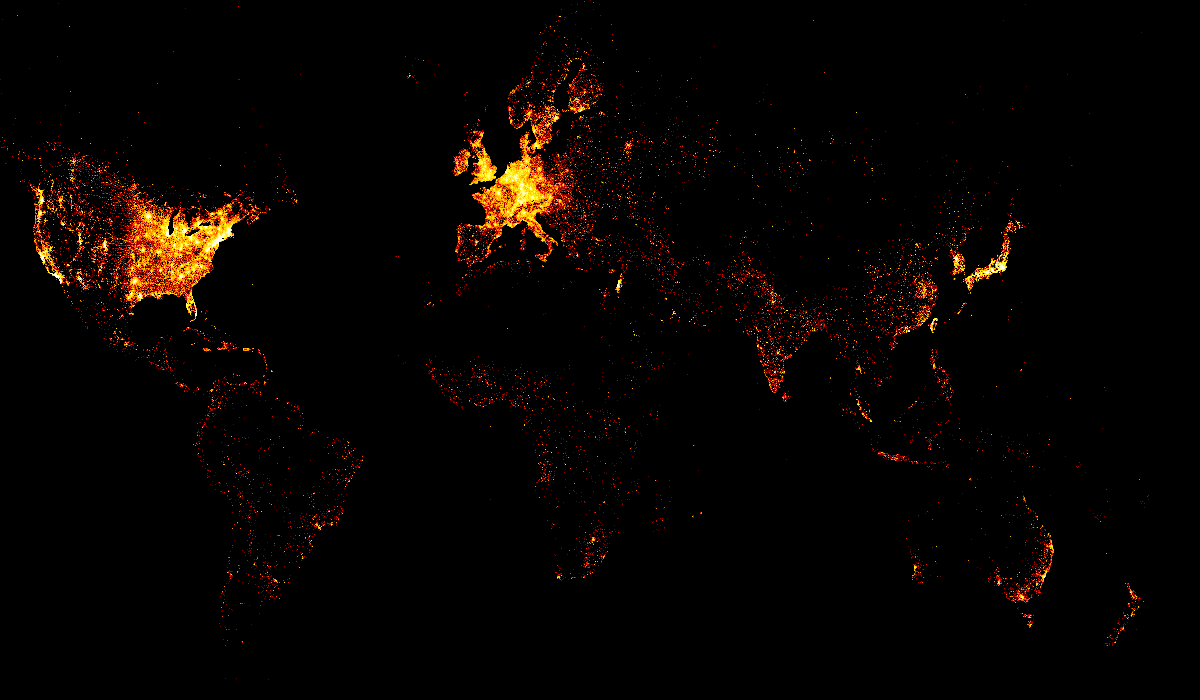

In [264]:
from colorcet import fire
export(tf.shade(agg, cmap = cm(fire,0.2), how='eq_hist'),"census_ds_fire_eq_hist")

This should reveal even more of the detail than the gray colormaps above.  

You can also import colormaps directly from `matplotlib.cm` or `bokeh.palettes`, but only a few of those will be perceptually uniform.  For instance, matplotlib's "hot" colormap is similar to colorcet's "fire", but reveals far less of the detail available in this data because it has long stretches of perceptually equivalent colors:

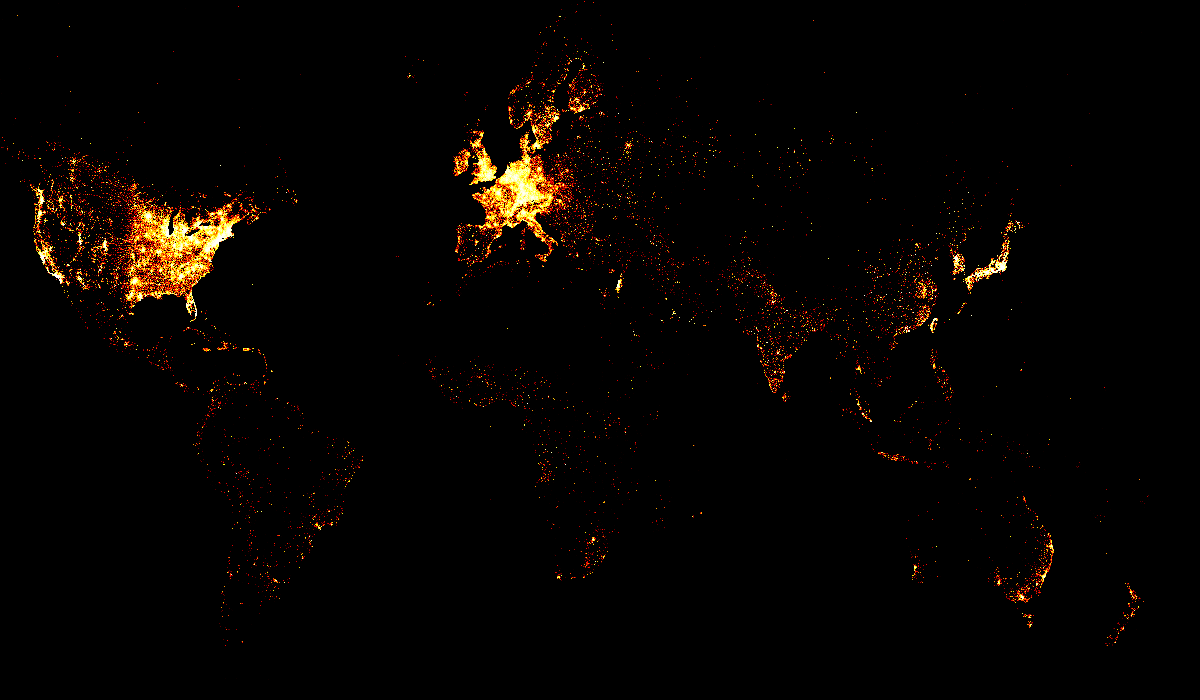

In [265]:
from matplotlib.cm import hot
export(tf.shade(agg, cmap = hot, how='eq_hist'),"census_ds_mhot_eq_hist")

Also note that the ``cm()`` function used here that lets us switch backgrounds and prevent undersampling only supports Bokeh palettes (either provided by Bokeh or from cetcolors), though we do provide Bokeh-palette versions of matplotlib's perceptually uniform `viridis` and `inferno` colormaps from within datashader:

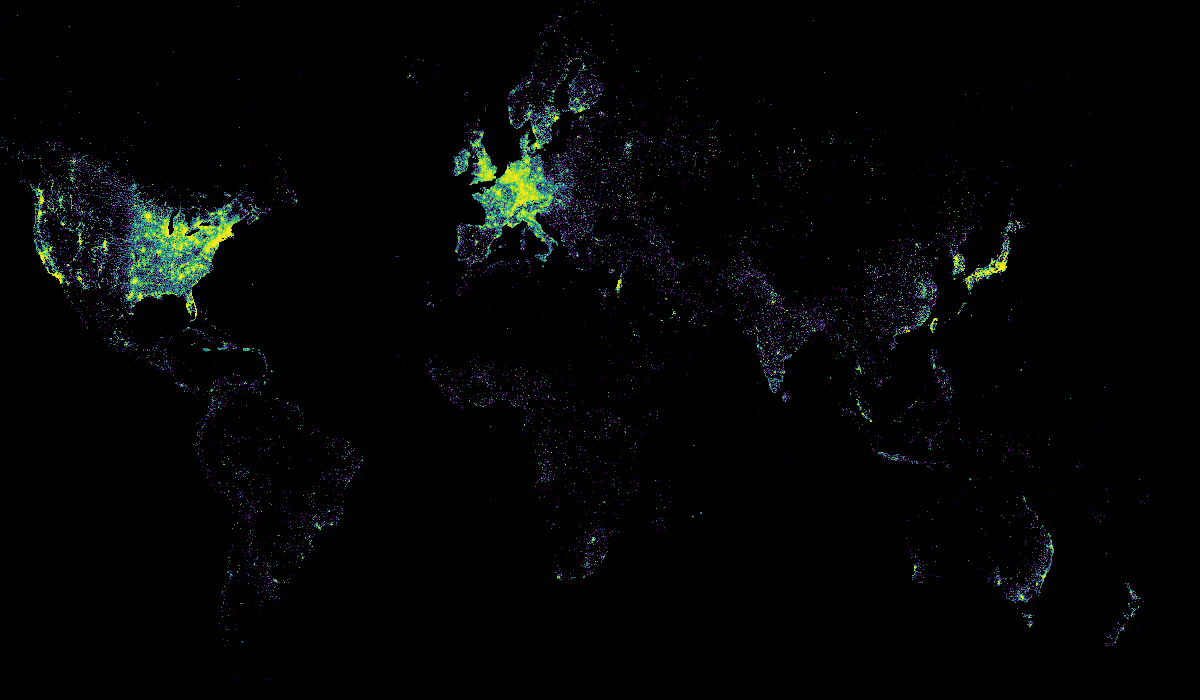

In [266]:
from datashader.colors import viridis
export(tf.shade(agg, cmap=cm(viridis), how='eq_hist'),"census_viridis_eq_hist")

For plotting magnitudes of this type, it should be safe to use any of the "linear" colormaps from the [colorcet](https://github.com/pyviz/colorcet) package, depending on your preference.

Colormaps can also be used to address very specific questions about the data itself.  For instance, after histogram equalization, data should be uniformly distributed across the visible colormap.  Thus if we want to highlight e.g. the top 1% of pixels, by population density, we can use a colormap divided into 100 ranges, and just change the top one to a different color:

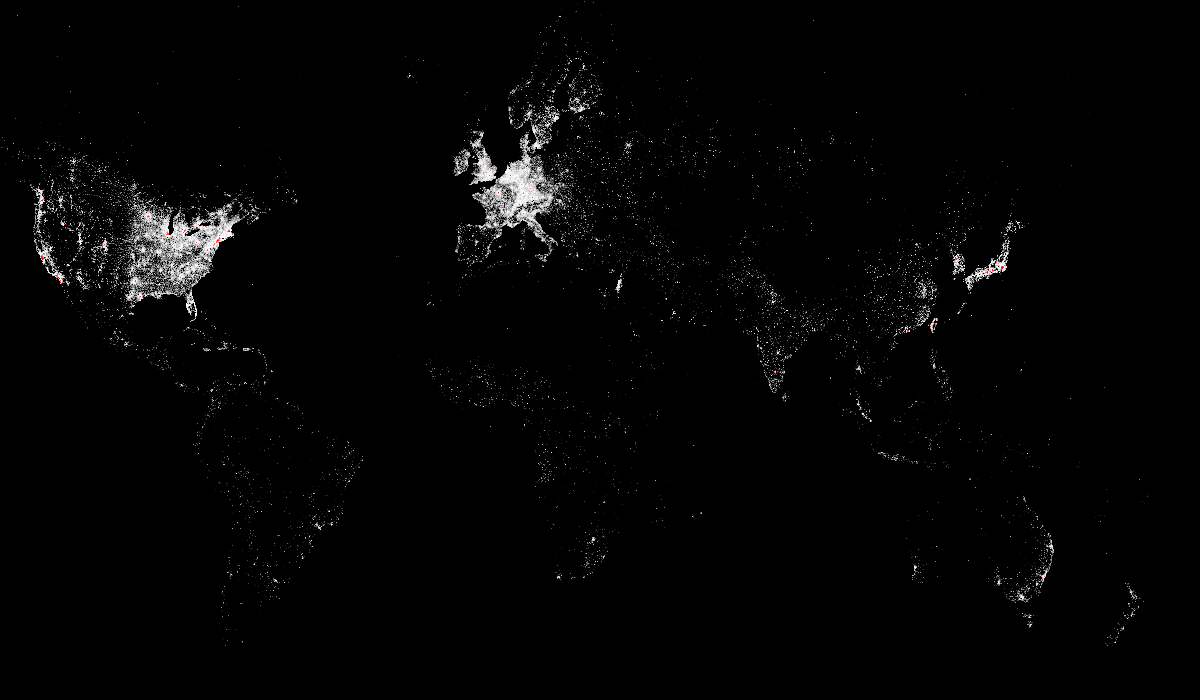

In [267]:
grays2 = cm([(i,i,i) for i in np.linspace(0,255,99)])
grays2 += ["red"]
export(tf.shade(agg, cmap = grays2, how='eq_hist'),"census_gray_redhot1_eq_hist")

The above plot now conveys nearly all the information available in the linear plot, i.e. that only a few pixels have the very highest population densities, while also conveying the structure of the data at all population density ranges via histogram equalization.  And in no case was any parameter value chosen based on the data itself, just on the question we wanted to ask about the data, which is crucial for posing and answering questions objectively using visualizations.

### Categorical data (race)

Since we've got the racial category for every pixel, we can use color to indicate the category value, instead of just extending dynamic range or highlighting percentiles as above.  To do this, we first need to set up a color key for each category label, with different color keys as appropriate to make colors that stand out against the background:

In [ ]:
if background == "black":
      color_key = {'w':'aqua', 'b':'lime',  'a':'red', 'h':'fuchsia', 'o':'yellow' }
else: color_key = {'w':'blue', 'b':'green', 'a':'red', 'h':'orange',  'o':'saddlebrown'}

We can now aggregate the counts *per race* into grids, using `ds.count_cat`, instead of just a single grid with the total counts (via the default aggregate reducer `ds.count`), and then generate an image by colorizing each pixel using the aggregate information from each category for that pixel's location:

In [269]:
def create_image(longitude_range, latitude_range, w=plot_width, h=plot_height):
    x_range,y_range=webm(longitude_range,latitude_range)
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'easting', 'northing', ds.count_cat('race'))
    img = tf.shade(agg, color_key=color_key, how='eq_hist')
    return img

The result shows that the USA is overwhelmingly white, apart from some predominantly Hispanic regions along the Southern border, some regions with high densities of blacks in the Southeast, and a few isolated areas of category "Other" in the West (primarily Native American reservation areas).

In [270]:
%%time
export(create_image(*USA),"Zoom 0 - USA")

KeyError: 'easting'

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:36372 remote=tcp://127.0.0.1:41143>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:36374 remote=tcp://127.0.0.1:41143>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:36452 remote=tcp://127.0.0.1:41143>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:36454 remote=tcp://127.0.0.1:41143>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:36456 remote=tcp://127.0.0.1:41143>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:36458 remote=tcp://127.0.0.1:41143>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:36466 remote=tcp://127.0.0.1:41143>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:36468 remote=tcp://127.0.0.1:41143>
distribu

Interestingly, the racial makeup has some sharp boundaries around urban centers, as we can see if we zoom in (which should be faster than the full USA using this SpatialPointsFrame):

In [ ]:
%%time
export(create_image(*LakeMichigan),"Zoom 1 - Lake Michigan")

With sufficient zoom, it becomes clear that Chicago (like most large US cities) has both a wide diversity of racial groups, and profound geographic segregation:

In [ ]:
%%time
export(create_image(*Chicago),"Zoom 2 - Chicago")

Eventually, we can zoom in far enough to see individual datapoints.  Here we can see that the Chinatown region of Chicago has, as expected, very high numbers of Asian residents, and that other nearby regions (separated by geographic features like rivers, railroads and highways) have other races, varying in how uniformly segregated they are:

In [ ]:
%%time
export(tf.spread(create_image(*Chinatown),px=plot_width//400),"Zoom 3 - Chinatown")

Note that here we've used the `tf.spread` function to enlarge each point to cover multiple pixels so that each point is clearly visible, which adds a bit to the computation time. 

### Other cities, for comparison

Different US cities have very different racial makeup, but they all appear highly segregated:

In [268]:
export(create_image(*NewYorkCity),"NYC")

NameError: name 'create_image' is not defined

In [ ]:
export(create_image(*LosAngeles),"LosAngeles")

In [ ]:
export(create_image(*Houston),"Houston")

In [ ]:
export(create_image(*Atlanta),"Atlanta")

In [ ]:
export(create_image(*NewOrleans),"NewOrleans")

In [ ]:
export(create_image(*Austin),"Austin")

### Analyzing racial data through visualization

In addition to simply visualizing categorical data, we can break those categories down to ask specific questions.  For instance, if we switch back to the full USA and then select only the black population, we can see that blacks predominantly reside in urban areas except in the South and the East Coast:

In [ ]:
cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height)
aggc = cvs.points(df, 'easting', 'northing', ds.count_cat('race'))

export(tf.shade(aggc.sel(race='b'), cmap=cm(Greys9,0.25), how='eq_hist'),"USA blacks")

(Compare to "census_gray_eq_hist" above.)

Or we can show only those pixels where there is at least one resident from each of the racial categories white, black, Asian, and Hispanic, which mainly highlights urban areas (compare to "Zoom 0 - USA" above):

In [ ]:
agg2 = aggc.where((aggc.sel(race=['w', 'b', 'a', 'h']) > 0).all(dim='race')).fillna(0)
export(tf.shade(agg2, color_key=color_key, how='eq_hist'),"USA all")

In the above plot, the colors still show the racial makeup of each pixel, but the pixels have been filtered so that only those with at least one datapoint from every race are shown.

Or we can look at all pixels where there are more black than white datapoints, which highlights predominantly black neighborhoods of large urban areas across most of the USA, but some rural areas and small towns in the South:

In [ ]:
export(tf.shade(aggc.where(aggc.sel(race='w') < aggc.sel(race='b')).fillna(0), color_key=color_key, how='eq_hist'),"more_blacks")

Here the colors still show the predominant race in that pixel, which is black for many of these, but in Southern California it looks like there are several large neighborhoods where blacks outnumber whites but both are outnumbered by Hispanics.

In any case, the thing to do here is to try out your own hypotheses and questions, whether for the USA or for your own region. The aggregate array is just an ordinary xarray multidimensional array, so you can see the [xarray documentation](http://xarray.pydata.org) for how to select and transform that data.  E.g. you can try posing questions that are independent of the number of datapoints in each pixel, since that varies so much geographically, by normalizing the aggregated data in various ways. Now that the data's been aggregated but not yet rendered to the screen, there is an infinite range of queries you can pose!

### Interactive HoloViews+Bokeh plots overlaid with map data

The above plots all show static images on their own.  datashader is independent of Bokeh, HoloViews, or other visualization libraries, but when combined with HoloViews and Bokeh, it is easy to make interactive plots that incorporate maps, satellite imagery, annotations, legends, and hover-tool information.

To do this, let's import what we need and set some defaults:

In [ ]:
import holoviews as hv, geoviews as gv, geoviews.tile_sources as gts
from holoviews.operation.datashader import datashade, dynspread
from holoviews import opts
hv.extension('bokeh')

opts.defaults(
    opts.Overlay(width=900, height=525, xaxis=None, yaxis=None))

And then create an interactive plot using a dynamic wrapper ``datashade`` that calls datashader whenever someone zooms or pans the plot.  In this pipeline, we'll use the `tf.dynspread` function to automatically increase the plotted size of each datapoint, once you've zoomed in so far that datapoints no longer have nearby neighbors.  We'll also add some image tiles in the background, using satellite-derived maps:

In [ ]:
points = hv.Points(gv.Dataset(df, kdims=['easting', 'northing'], vdims=['race']))
race = dynspread(datashade(points, color_key=color_key, element_type=gv.Image, aggregator=ds.count_cat('race')))
gts.EsriImagery() * race

Note that you need a live copy of the notebook, with a running server; zooming and panning will be disabled (or only work partially, which can be confusing!) in a static exported copy like on anaconda.org.

You can similarly zoom into the population density data (ignoring race):

In [ ]:
population = dynspread(datashade(points, cmap=fire, element_type=gv.Image))
gts.EsriImagery() * population * gts.StamenLabels().options(level="annotation")

The dashboard.ipynb example shows this same census data in the context of an interactive dashboard, including color keys and hover information that help reveal the magnitudes at every location even while the plot faithfully reveals the structure.